
# MMF1921/MIE377 - Backtesting Template

The purpose of this program is to provide a template with which to develop Project 2. The project requires you to test different models  (and/or different model combinations) to create an asset management algorithm.

This template will be used by the instructor and TA to assess your trading algorithm using different datasets.

# PLEASE DO NOT MODIFY THIS TEMPLATE (for Project submission purposes)

# 1. Read input files

In [1]:
import time
import math
from scipy.stats import gmean
import matplotlib.pyplot as plt
from services.project_function import *
import pandas as pd

In [11]:
df = pd.read_csv("MIE377_AssetPrices1.csv", index_col=0)
print(df.shape)
no_assets = df.shape[1]

(127, 21)


In [3]:
ps = []
times = []
sharpes = []
turnovers = []

for p in range(1, no_assets+1):

    adjClose = pd.read_csv("MIE377_AssetPrices1.csv", index_col=0)
    factorRet = pd.read_csv("MIE377_FactorReturns1.csv", index_col=0)

    adjClose.index = pd.to_datetime(adjClose.index)
    factorRet.index = pd.to_datetime(factorRet.index)

    # Initial budget to invest ($100,000)
    initialVal = 100000

    # Length of investment period (in months)
    investPeriod = 6

    # divide the factor returns by  100
    factorRet = factorRet/100

    #rf and factor returns
    riskFree = factorRet['RF']
    factorRet = factorRet.loc[:,factorRet.columns != 'RF'];

    #Identify the tickers and the dates
    tickers = adjClose.columns
    dates   = factorRet.index

    # Calculate the stocks monthly excess returns
    # pct change and drop the first null observation
    returns = adjClose.pct_change(1).iloc[1:, :]


    returns = returns  - np.diag(riskFree.values) @ np.ones_like(returns.values)
    # Align the price table to the asset and factor returns tables by discarding the first observation.
    adjClose = adjClose.iloc[1:,:]

    assert adjClose.index[0] == returns.index[0]
    assert adjClose.index[0] == factorRet.index[0]

    # Start of out-of-sample test period
    testStart = returns.index[0] + pd.offsets.DateOffset(years=5)

    #End of the first investment period
    testEnd = testStart + pd.offsets.DateOffset(months=investPeriod) -  pd.offsets.DateOffset(days = 1)

    # End of calibration period
    calEnd = testStart -  pd.offsets.DateOffset(days = 1)

    # Total number of investment periods
    NoPeriods = math.ceil((returns.index[-1].to_period('M') - testStart.to_period('M')).n / investPeriod)

    # Number of assets
    n  = len(tickers)

    # Preallocate space for the portfolio weights (x0 will be used to calculate
    # the turnover rate)
    x  = np.zeros([n, NoPeriods])
    x0 = np.zeros([n, NoPeriods])

    # Preallocate space for the portfolio per period value and turnover
    currentVal = np.zeros([NoPeriods, 1])
    turnover   = np.zeros([NoPeriods, 1])

    #Initiate counter for the number of observations per investment period
    toDay = 0

    # Measure runtime: start the clock
    start_time = time.time()

    # Empty list to measure the value of the portfolio over the period
    portfValue = []

    for t in range(NoPeriods):
        # Subset the returns and factor returns corresponding to the current calibration period.
        periodReturns = returns[returns.index <= calEnd]
        periodFactRet = factorRet[factorRet.index <= calEnd]

        current_price_idx = (calEnd - pd.offsets.DateOffset(months=1) <= adjClose.index)&(adjClose.index <= calEnd)
        currentPrices = adjClose[current_price_idx]

        # Subset the prices corresponding to the current out-of-sample test period.
        periodPrices_idx = (testStart <= adjClose.index)&(adjClose.index <= testEnd)
        periodPrices = adjClose[periodPrices_idx]

        assert len(periodPrices) == investPeriod
        assert len(currentPrices) == 1
        # Set the initial value of the portfolio or update the portfolio value
        if t == 0:
            currentVal[0] = initialVal
        else:
            currentVal[t] = currentPrices @  NoShares.values.T
            #Store the current asset weights (before optimization takes place)
            x0[:,t] = currentPrices.values*NoShares.values/currentVal[t]

        #----------------------------------------------------------------------
        # Portfolio optimization
        # You must write code your own algorithmic trading function
        #----------------------------------------------------------------------
        x[:,t] = project_function(periodReturns, periodFactRet, x0[:,t], p)

        #Calculate the turnover rate
        if t > 0:
            turnover[t] = np.sum( np.abs( x[:,t] - x0[:,t] ) )

        # Number of shares your portfolio holds per stock
        NoShares = x[:,t]*currentVal[t]/currentPrices

        # Update counter for the number of observations per investment period
        fromDay = toDay
        toDay   = toDay + len(periodPrices)

        # Weekly portfolio value during the out-of-sample window
        portfValue.append(periodPrices@ NoShares.values.T)

        # Update your calibration and out-of-sample test periods
        testStart = testStart + pd.offsets.DateOffset(months=investPeriod)
        testEnd   = testStart + pd.offsets.DateOffset(months=investPeriod) - pd.offsets.DateOffset(days=1)
        calEnd    = testStart - pd.offsets.DateOffset(days=1)

    portfValue = pd.concat(portfValue, axis = 0)
    end_time = time.time()

    #--------------------------------------------------------------------------
    # 3.1 Calculate the portfolio average return, standard deviation, Sharpe ratio and average turnover.
    #-----------------------------------------------------------------------
    # Calculate the observed portfolio returns
    portfRets = portfValue.pct_change(1).iloc[1:,:]

    # Calculate the portfolio excess returns
    portfExRets = portfRets.subtract(riskFree[(riskFree.index >= portfRets.index[0])&(riskFree.index <= portfRets.index[-1])], axis = 0)

    # Calculate the portfolio Sharpe ratio
    SR = ((portfExRets + 1).apply(gmean, axis=0) - 1)/portfExRets.std()

    # Calculate the average turnover rate
    avgTurnover = np.mean(turnover[1:])

    #Print Sharpe ratio and Avg. turnover to the console
    print(p)
    print("Elasped time is "+ str(end_time - start_time) + ' seconds')
    print('Sharpe ratio: ', str(SR[0]))
    print('Avg. turnover: ', str(avgTurnover))
    print('\n')

    ps.append(p)
    times.append(end_time - start_time)
    sharpes.append(SR[0])
    turnovers.append(avgTurnover)

1
Elasped time is 1.5997884273529053 seconds
Sharpe ratio:  0.5712769950658302
Avg. turnover:  0.40213835274521026


2
Elasped time is 1.3308322429656982 seconds
Sharpe ratio:  0.5402585554901231
Avg. turnover:  0.4547771169728446


3
Elasped time is 1.519097089767456 seconds
Sharpe ratio:  0.572167890135098
Avg. turnover:  0.5050239363326756


4
Elasped time is 0.9842636585235596 seconds
Sharpe ratio:  0.6112571118810813
Avg. turnover:  0.48775225559405655


5
Elasped time is 0.9482557773590088 seconds
Sharpe ratio:  0.5879492229950765
Avg. turnover:  0.4803411311503322


6
Elasped time is 1.6389484405517578 seconds
Sharpe ratio:  0.5889064115247036
Avg. turnover:  0.5151690785907095


7
Elasped time is 1.7137274742126465 seconds
Sharpe ratio:  0.5914946810752222
Avg. turnover:  0.5618281108538952


8
Elasped time is 1.3752679824829102 seconds
Sharpe ratio:  0.5897645901927064
Avg. turnover:  0.5435667466640587


9
Elasped time is 0.910447359085083 seconds
Sharpe ratio:  0.56914752337

In [13]:
df = pd.DataFrame({'p': ps, 'Time': times, 'Sharpe Ratio': sharpes, 'Turnover': turnovers},
                  index=ps)
df

,p,Time,Sharpe Ratio,Turnover
1,1,1.599788,0.571277,0.402138
2,2,1.330832,0.540259,0.454777
3,3,1.519097,0.572168,0.505024
4,4,0.984264,0.611257,0.487752
5,5,0.948256,0.587949,0.480341
6,6,1.638948,0.588906,0.515169
7,7,1.713727,0.591495,0.561828
8,8,1.375268,0.589765,0.543567
9,9,0.910447,0.569148,0.537450
10,10,0.942444,0.547625,0.558474


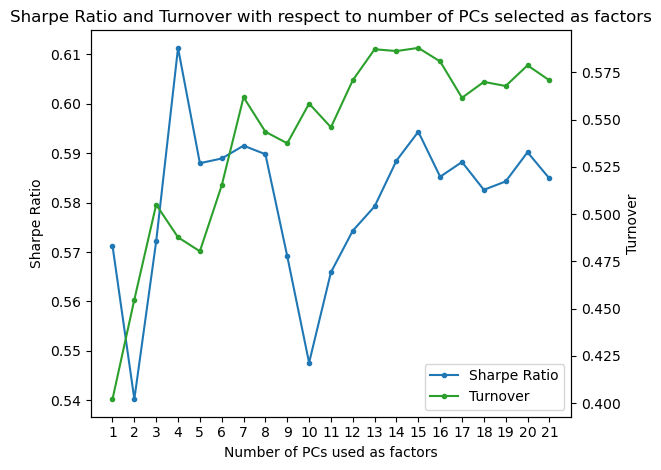

In [14]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

plt.title('Sharpe Ratio and Turnover with respect to number of PCs selected as factors')

ax1.plot(df['p'].values, df['Sharpe Ratio'].values, label='Sharpe Ratio', marker='.', color='tab:blue')
ax1.plot([], [], label='Turnover', marker='.', color='tab:green')
ax2.plot(df['p'].values, df['Turnover'].values, label='Turnover', marker='.', color='tab:green')
ax1.set_xlabel('Number of PCs used as factors')
ax1.set_ylabel('Sharpe Ratio')
ax2.set_ylabel('Turnover')

ax1.legend(loc='lower right')
plt.xticks(range(1, no_assets+1))
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

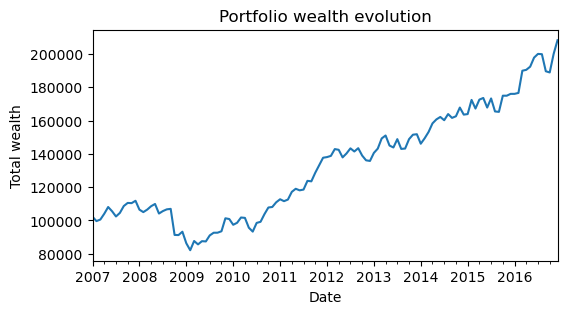

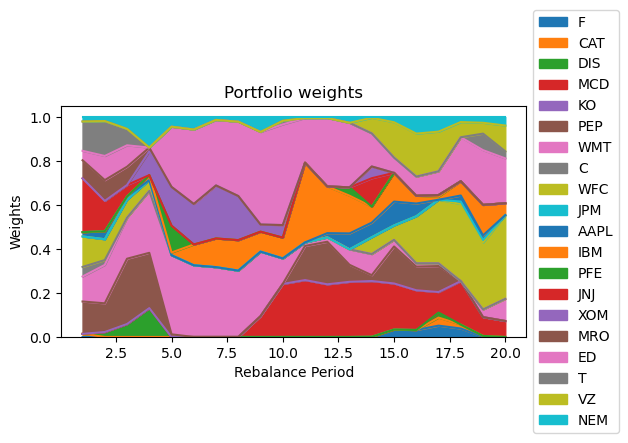

In [7]:
#--------------------------------------------------------------------------
# 3.2 Portfolio wealth evolution plot
#--------------------------------------------------------------------------
# Calculate the dates of the out-of-sample period

fig = plt.figure(1)
portfValue.plot(title = 'Portfolio wealth evolution',
                ylabel = 'Total wealth',
                figsize = (6, 3),
                legend = False)
plt.savefig("images/wealth.svg")

#--------------------------------------------------------------------------
# 3.3 Portfolio weights plot
#--------------------------------------------------------------------------
# Portfolio weights

fig2 = plt.figure(2);
x[x < 0] = 0
weights = pd.DataFrame(x, index = tickers)
weights.columns = [col + 1 for col in weights.columns]
weights.T.plot.area(title = 'Portfolio weights',
                  ylabel = 'Weights', xlabel = 'Rebalance Period',
                  figsize = (6, 3),
                  legend = True, stacked = True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig("images/weights.svg");
#
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# % Program End

### 0.12% maximum absolute difference between the returns generated via Python and returns generated via MATLAB can be observed

### Terminal wealth between MATLAB and Python is within 0.1%